# Superpoint test 

In [47]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import math
import random


DATA_ROOT = os.path.expanduser("../data")
TILE_DIR  = os.path.join(DATA_ROOT, "rubin_tiles_ecdfs_gr_i")


class RubinTileDataset(Dataset):
    def __init__(self, tile_dir, augment=False):
        self.files = sorted(glob.glob(os.path.join(tile_dir, "*.npz")))
        self.augment = augment
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        f = np.load(self.files[idx])
        img = torch.from_numpy(f["img"]).float()   # [3,H,W]
        var = torch.from_numpy(f["var"]).float()   # [3,H,W]
        msk = torch.from_numpy(f["mask"]).long()   # [H,W]
        
        if self.augment:
            img, var, msk = self.apply_augmentation(img, var, msk)
        
        return img, var, msk
    
    def apply_augmentation(self, img, var, msk):
        """
        Apply same geometric transformation to all arrays.
        img: [3, H, W]
        var: [3, H, W]  
        msk: [H, W]
        """
        # Random horizontal flip (flip along width axis)
        if random.random() > 0.5:
            img = torch.flip(img, [-1])  # flip last dimension (W)
            var = torch.flip(var, [-1])
            msk = torch.flip(msk, [-1])
        
        # Random vertical flip (flip along height axis)
        if random.random() > 0.5:
            img = torch.flip(img, [-2])  # flip second-to-last dimension (H)
            var = torch.flip(var, [-2])
            msk = torch.flip(msk, [-2])
        
        # Random 90° rotation (k=0,1,2,3 for 0°,90°,180°,270°)
        k = random.randint(0, 3)
        if k > 0:
            # For [3,H,W] tensors, rotate the last two dims (H,W)
            img = torch.rot90(img, k, dims=[-2, -1])
            var = torch.rot90(var, k, dims=[-2, -1])
            # For [H,W] tensor, rotate the two dims
            msk = torch.rot90(msk, k, dims=[-2, -1])
        
        return img, var, msk

ds = RubinTileDataset(TILE_DIR)
dl = DataLoader(ds, batch_size=2, shuffle=True, num_workers=2)

img, var, msk = next(iter(dl))
img.shape, var.shape, msk.shape


(torch.Size([2, 3, 512, 512]),
 torch.Size([2, 3, 512, 512]),
 torch.Size([2, 3, 512, 512]))

In [43]:

def robust_norm(x: torch.Tensor, eps: float = 1e-6, clip: float = 8.0) -> torch.Tensor:
    """
    Robust per-image normalization:
      (x - median) / (1.4826 * MAD)
    Optionally clip to [-clip, clip] to stabilize training.
    x: [..., H, W] or [H, W]
    """
    med = x.median()
    mad = (x - med).abs().median()
    x = (x - med) / (1.4826 * mad + eps)
    if clip is not None:
        x = x.clamp(-clip, clip)
    return x


class SuperPointLite(nn.Module):
    def __init__(self, desc_dim=64):
        super().__init__()

        # stride 2 instead of 4 (only one pooling)
        self.backbone = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 512 -> 256

            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
        )

        self.det_head  = nn.Conv2d(128, 1, 1)
        nn.init.constant_(self.det_head.bias, -4.0)  # starts near ~0.018
        self.desc_head = nn.Conv2d(128, desc_dim, 1)

    def forward(self, x):
        f = self.backbone(x)
        heatmap = torch.sigmoid(self.det_head(f))          # [N,1,256,256]
        desc = F.normalize(self.desc_head(f), p=2, dim=1)  # [N,D,256,256]
        return heatmap, desc

def sample_affine_params():
    return dict(
        angle=random.uniform(-5, 5),
        translate=(random.uniform(-5, 5), random.uniform(-5, 5)),
        scale=random.uniform(0.98, 1.02),
        shear=random.uniform(-2, 2),
    )

def apply_affine(img, params, interpolation=TF.InterpolationMode.BILINEAR):
    """
    img: [H,W] or [1,H,W] (torch tensor)
    returns: same shape as input
    NOTE: TF.affine expects [C,H,W] tensor (no batch).
    """
    if img.ndim == 2:
        img_in = img.unsqueeze(0)          # [1,H,W]
        out = TF.affine(img_in, interpolation=interpolation, **params)  # [1,H,W]
        return out.squeeze(0)              # [H,W]
    elif img.ndim == 3:
        return TF.affine(img, interpolation=interpolation, **params)    # [C,H,W]
    else:
        raise ValueError(f"apply_affine expects [H,W] or [C,H,W], got shape {tuple(img.shape)}")

def apply_affine_with_padding(img, params, interpolation=TF.InterpolationMode.BILINEAR, pad=32):
    """
    Pad image before affine, then crop back to avoid edge artifacts.
    """
    if img.ndim == 2:
        img_in = img.unsqueeze(0)
        need_squeeze = True
    else:
        img_in = img
        need_squeeze = False
    
    # Pad
    img_padded = F.pad(img_in, (pad, pad, pad, pad), mode='replicate')
    
    # Warp
    warped = TF.affine(img_padded, interpolation=interpolation, **params)
    
    # Crop back to original size
    out = warped[:, pad:-pad, pad:-pad]
    
    return out.squeeze(0) if need_squeeze else out

def detector_losses(h0, h0_warped, h1, p_tgt=0.01):
    """
    h0_warped should be h0 warped with the same affine used on the image.
    """
    loss_repeat = F.mse_loss(h0_warped, h1)

    p0 = h0.mean()
    p1 = h1.mean()
    loss_density = (p0 - p_tgt).pow(2) + (p1 - p_tgt).pow(2)
    loss_sparse = (p0 + p1) * 0.5
    loss_peak   = -((h0**2).mean() + (h1**2).mean()) * 0.5
    loss_floor = F.relu(p_tgt * 0.5 - p0) + F.relu(p_tgt * 0.5 - p1)

    return loss_repeat, loss_density, loss_sparse, loss_peak,loss_floor

def local_contrast_loss(h, k=7):
    """
    Encourage local maxima by penalizing pixels that are close to their local average.
    h: [N,1,H,W]
    """
    avg = F.avg_pool2d(h, k, stride=1, padding=k//2)
    return -((h - avg)**2).mean()


def sample_from_heatmap(h, num=256, thr_rel=0.2):
    """
    h: [1,1,hh,ww]
    returns xs, ys on heatmap grid
    """
    hm = h[0,0]
    thr = (thr_rel * hm.max()).clamp(min=0.0)
    ys, xs = torch.where(hm > thr)
    if xs.numel() < num:
        return None
    idx = torch.randperm(xs.numel(), device=xs.device)[:num]
    return xs[idx], ys[idx]

def desc_match_loss(d0, d1, xs, ys):
    """
    d0, d1: [1,D,hh,ww]
    """
    v0 = d0[0, :, ys, xs].T
    v1 = d1[0, :, ys, xs].T
    return F.smooth_l1_loss(v0, v1)





In [44]:
# --- UPDATED TRAINING CELL (drop-in) ---

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SuperPointLite().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

# loss weights (reasonable starts)
w_rep   = 1.0
w_den   = 50.0     
w_sparse= 0.2
w_peak  = 0.1
w_desc  = 1.0
w_floor = 1.0
p_tgt   = 0.02     


for step, (img, var, msk) in enumerate(dl):
    # pick a random band
    b = torch.randint(0, img.shape[1], (1,)).item()

    # x0: [N,1,512,512], robust-normalized per tile
    x0 = img[:, b].to(device)                             # [N,512,512]
    x0 = torch.stack([robust_norm(xi) for xi in x0], 0)    # [N,512,512]
    x0 = x0.unsqueeze(1)                                   # [N,1,512,512]

    # build warped pair with known params (per sample)
    params_list = [sample_affine_params() for _ in range(x0.shape[0])]
    
    # warp image (bilinear)
    x1 = torch.stack([apply_affine_with_padding(x0[i,0], params_list[i]) for i in range(x0.shape[0])], 0).unsqueeze(1)
    
    # forward
    h0, d0 = model(x0)
    h1, d1 = model(x1)
    
    # warp heatmap (bilinear is OK)
    h0w = torch.stack([apply_affine_with_padding(h0[i,0], params_list[i]) for i in range(h0.shape[0])], 0).unsqueeze(1)


    # detector losses
    loss_rep, loss_den, loss_sparse, loss_peak, loss_floor = detector_losses(h0, h0w, h1, p_tgt=p_tgt)


    # descriptor loss: sample points from confident regions in h0
    loss_desc = 0.0
    n_used = 0
    for i in range(x0.shape[0]):
        kps = sample_from_heatmap(h0[i:i+1], num=256, thr_rel=0.2)
        if kps is None:
            continue
        xs, ys = kps
        loss_desc = loss_desc + desc_match_loss(d0[i:i+1], d1[i:i+1], xs, ys)
        n_used += 1
    if n_used > 0:
        loss_desc = loss_desc / n_used
    else:
        loss_desc = torch.tensor(0.0, device=device)

    # total loss
    loss = (
        w_rep    * loss_rep +
        w_den    * loss_den +
        w_sparse * loss_sparse +
        w_peak   * loss_peak +
        w_desc   * loss_desc+
        w_floor * loss_floor     )

    opt.zero_grad(set_to_none=True)
    loss.backward()
    opt.step()
    if step % 5 == 0:
        print(
            f"step={step} "
            f"loss={loss.item():.4g} "
            f"mean_h={h0.mean().item():.4g} "
            f"max_h={h0.max().item():.4g} "
            f"den={loss_den.item():.4g}")



step=0 loss=0.004087 mean_h=0.01816 max_h=0.01907 den=6.787e-06
step=5 loss=0.003958 mean_h=0.01888 max_h=0.02001 den=2.832e-06
step=10 loss=0.003907 mean_h=0.01917 max_h=0.02026 den=1.684e-06
step=15 loss=0.003894 mean_h=0.01913 max_h=0.01997 den=1.83e-06
step=20 loss=0.003883 mean_h=0.01903 max_h=0.01961 den=2.176e-06
step=25 loss=0.003881 mean_h=0.01901 max_h=0.01959 den=2.208e-06
step=30 loss=0.003875 mean_h=0.01906 max_h=0.01961 den=2.019e-06
step=35 loss=0.003874 mean_h=0.01907 max_h=0.01967 den=1.944e-06
step=40 loss=0.003872 mean_h=0.01904 max_h=0.01953 den=2.052e-06
step=45 loss=0.003873 mean_h=0.01905 max_h=0.01952 den=2.03e-06
step=50 loss=0.003872 mean_h=0.01907 max_h=0.01948 den=1.935e-06
step=55 loss=0.003872 mean_h=0.01908 max_h=0.01952 den=1.893e-06
step=60 loss=0.003871 mean_h=0.01905 max_h=0.01942 den=1.979e-06
step=65 loss=0.003869 mean_h=0.01905 max_h=0.01947 den=1.954e-06
step=70 loss=0.00387 mean_h=0.01906 max_h=0.01952 den=1.936e-06


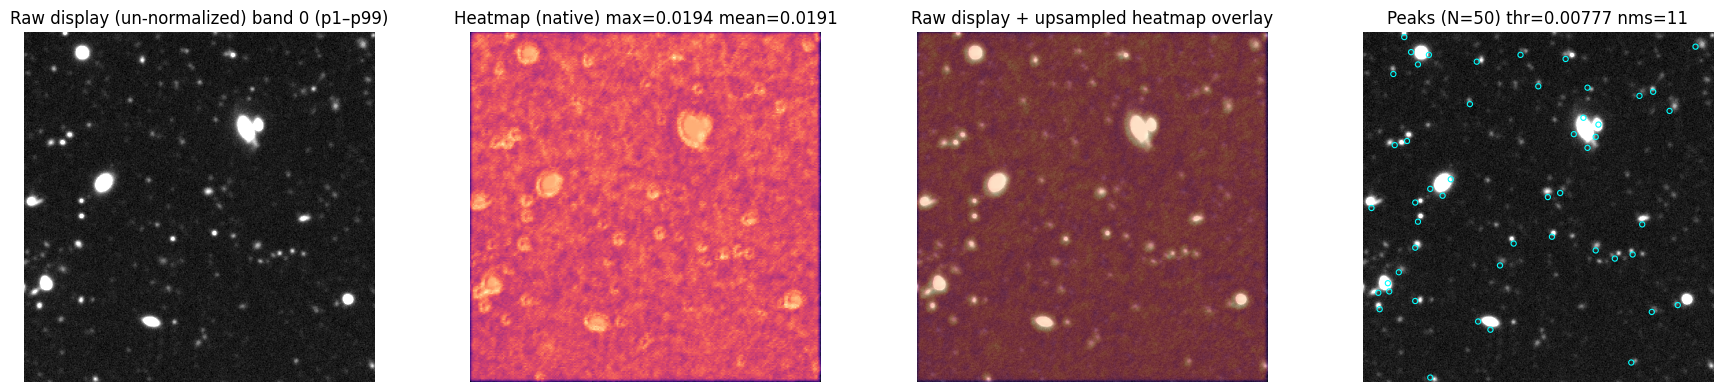

heatmap shape: (256, 256) -> raw shape: (512, 512)
thr_rel=0.4 => thr=0.007774; peaks=50


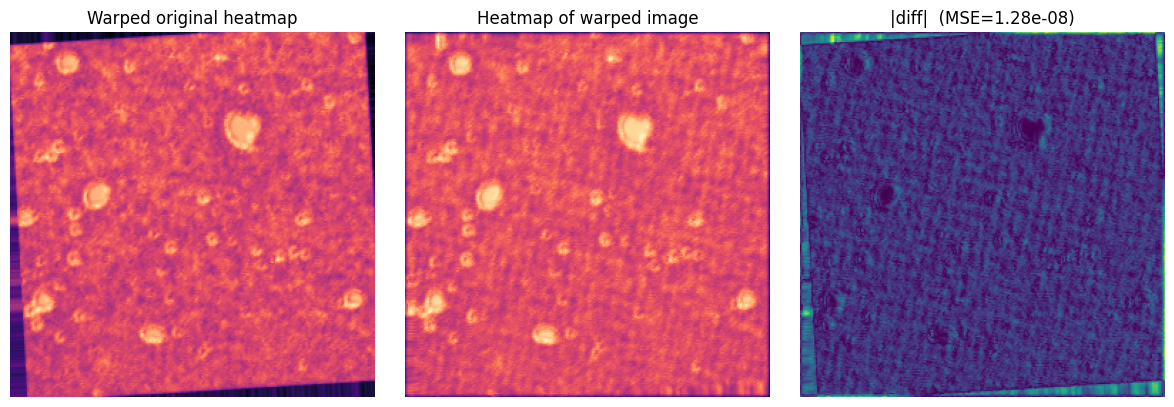

Repeatability MSE (lower is better): 1.28e-08


In [45]:
# -----------------------------
# knobs
# -----------------------------
band   = 0
p_lo, p_hi = 1, 99
nms_ks = 11
thr_rel = 0.4
max_peaks = 50

# repeatability check knobs
do_repeatability_check = True
rep_nms_ks = 11

# -----------------------------
# get one tile
# -----------------------------
img, var, msk = next(iter(dl))
raw0 = img[0, band]                       # [512,512] (UN-normalized)

device = next(model.parameters()).device
model.eval()

# IMPORTANT: normalize the same way as training
raw = robust_norm(raw0).to(device)        # [512,512] (normalized)

# -----------------------------
# run model
# -----------------------------
with torch.no_grad():
    x = raw.unsqueeze(0).unsqueeze(0)     # [1,1,512,512]
    heatmap, desc = model(x)              # heatmap: [1,1,h,w]
    h = heatmap[0,0]                      # [h,w]

# -----------------------------
# NMS + threshold (relative to max)
# -----------------------------
pad = nms_ks // 2
mx = F.max_pool2d(h[None,None], nms_ks, stride=1, padding=pad)[0,0]
thr = (thr_rel * h.max()).clamp(min=0.0)
keep = (h == mx) & (h > thr)

ys_hm, xs_hm = torch.where(keep)
scores = h[ys_hm, xs_hm]

# cap number of peaks
if scores.numel() > max_peaks:
    idx = torch.argsort(scores, descending=True)[:max_peaks]
    xs_hm, ys_hm, scores = xs_hm[idx], ys_hm[idx], scores[idx]

# -----------------------------
# upsample heatmap to raw resolution
# -----------------------------
with torch.no_grad():
    h_up = F.interpolate(heatmap, size=raw.shape, mode="bilinear", align_corners=False)[0,0]  # [512,512]

# map peak coords from heatmap grid -> raw grid
H, W = raw.shape
hh, ww = h.shape
xs = xs_hm.float() * (W / ww)
ys = ys_hm.float() * (H / hh)

# -----------------------------
# display scaling for *UN-normalized* raw (so you see astronomy nicely)
# -----------------------------
raw0_np = raw0.cpu().numpy()
lo, hi = np.percentile(raw0_np, (p_lo, p_hi))

h_np   = h.detach().cpu().numpy()
hup_np = h_up.detach().cpu().numpy()

# -----------------------------
# plots (raw display uses raw0, model input uses raw)
# -----------------------------
fig, axs = plt.subplots(1, 4, figsize=(18, 4))

axs[0].imshow(raw0_np, origin="lower", cmap="gray", vmin=lo, vmax=hi)
axs[0].set_title(f"Raw display (un-normalized) band {band} (p{p_lo}–p{p_hi})")
axs[0].axis("off")

axs[1].imshow(h_np, origin="lower", cmap="magma")
axs[1].set_title(f"Heatmap (native) max={h_np.max():.3g} mean={h_np.mean():.3g}")
axs[1].axis("off")

axs[2].imshow(raw0_np, origin="lower", cmap="gray", vmin=lo, vmax=hi)
axs[2].imshow(hup_np, origin="lower", cmap="magma", alpha=0.45)
axs[2].set_title("Raw display + upsampled heatmap overlay")
axs[2].axis("off")

axs[3].imshow(raw0_np, origin="lower", cmap="gray", vmin=lo, vmax=hi)
axs[3].scatter(xs.cpu(), ys.cpu(), s=14, facecolors="none", edgecolors="cyan", linewidths=0.8)
axs[3].set_title(f"Peaks (N={len(xs)}) thr={thr.item():.3g} nms={nms_ks}")
axs[3].axis("off")

plt.tight_layout()
plt.show()

print(f"heatmap shape: {tuple(h.shape)} -> raw shape: {tuple(raw.shape)}")
print(f"thr_rel={thr_rel} => thr={thr.item():.4g}; peaks={len(xs)}")

# -----------------------------
# repeatability check (optional but VERY informative)
# -----------------------------
if do_repeatability_check:
    params = sample_affine_params()

    with torch.no_grad():
        # warp normalized image (same distribution as training)
        xw = apply_affine_with_padding(raw, params).unsqueeze(0).unsqueeze(0)  # [1,1,512,512]
        hw, _ = model(xw)                                         # heatmap of warped image

        # warp original heatmap into warped frame (GPU-safe if apply_affine supports device)
        # if apply_affine only works on CPU in your env, do .cpu() then .to(device)
        h0w = apply_affine_with_padding(heatmap[0,0], params).unsqueeze(0).unsqueeze(0)

        # compare in heatmap grid (native)
        rep_mse = F.mse_loss(h0w, hw).item()

        # visualize repeatability
        h0w_np = h0w[0,0].detach().cpu().numpy()
        hw_np  = hw[0,0].detach().cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(h0w_np, origin="lower", cmap="magma")
    axs[0].set_title("Warped original heatmap")
    axs[0].axis("off")

    axs[1].imshow(hw_np, origin="lower", cmap="magma")
    axs[1].set_title("Heatmap of warped image")
    axs[1].axis("off")

    axs[2].imshow(np.abs(h0w_np - hw_np), origin="lower", cmap="viridis")
    axs[2].set_title(f"|diff|  (MSE={rep_mse:.3g})")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

    print(f"Repeatability MSE (lower is better): {rep_mse:.4g}")


In [56]:
# --- COMPLETE TRAINING CELL WITH CROSS-BAND MATCHING ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SuperPointLite().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
ds = RubinTileDataset(TILE_DIR, augment=True)
dl = DataLoader(ds, batch_size=2, shuffle=True, num_workers=2)

# Loss weights
w_rep        = 1.0
w_den        = 50.0     
w_sparse     = 0.2
w_peak       = 0.1
w_desc       = 1.0
w_floor      = 1.0
w_cross_band = 0.1  # ← Reduced from 1.0
p_tgt        = 0.02

num_epochs = 20

# Track best loss
best_loss = float('inf')
best_epoch = 0

for epoch in range(num_epochs):
    print(f"\n{'='*60}")
    print(f"EPOCH {epoch+1}/{num_epochs}")
    print(f"{'='*60}")
    
    epoch_losses = []  # Track all losses in this epoch
    
    for step, (img, var, msk) in enumerate(dl):
        # Pick a random band for geometric consistency training
        b = torch.randint(0, img.shape[1], (1,)).item()
        
        # x0: [N,1,512,512], robust-normalized per tile
        x0 = img[:, b].to(device)
        x0 = torch.stack([robust_norm(xi) for xi in x0], 0)
        x0 = x0.unsqueeze(1)
        
        # Build warped pair with known params (per sample)
        params_list = [sample_affine_params() for _ in range(x0.shape[0])]
        
        # Warp image (bilinear)
        x1 = torch.stack([apply_affine(x0[i,0], params_list[i]) for i in range(x0.shape[0])], 0).unsqueeze(1)
        
        # Forward through model
        h0, d0 = model(x0)
        h1, d1 = model(x1)
        
        # Warp heatmap (bilinear)
        h0w = torch.stack([apply_affine(h0[i,0], params_list[i]) for i in range(h0.shape[0])], 0).unsqueeze(1)
        
        # === DETECTOR LOSSES ===
        loss_rep, loss_den, loss_sparse, loss_peak, loss_floor = detector_losses(h0, h0w, h1, p_tgt=p_tgt)
        
        # === SAME-BAND DESCRIPTOR LOSS (geometric invariance) ===
        loss_desc = 0.0
        n_used = 0
        for i in range(x0.shape[0]):
            kps = sample_from_heatmap(h0[i:i+1], num=256, thr_rel=0.2)
            if kps is None:
                continue
            xs, ys = kps
            loss_desc = loss_desc + desc_match_loss(d0[i:i+1], d1[i:i+1], xs, ys)
            n_used += 1
        if n_used > 0:
            loss_desc = loss_desc / n_used
        else:
            loss_desc = torch.tensor(0.0, device=device)
        
        # === CROSS-BAND DESCRIPTOR LOSS (wavelength invariance) ===
        loss_cross_band = 0.0
        n_cross = 0
        
        if img.shape[1] >= 2:
            for i in range(img.shape[0]):
                bands = torch.randperm(img.shape[1])[:2]
                b1, b2 = bands[0].item(), bands[1].item()
                
                x_b1 = robust_norm(img[i, b1]).to(device).unsqueeze(0).unsqueeze(0)
                x_b2 = robust_norm(img[i, b2]).to(device).unsqueeze(0).unsqueeze(0)
                
                h_b1, d_b1 = model(x_b1)
                h_b2, d_b2 = model(x_b2)
                
                kps = sample_from_heatmap(h_b1, num=128, thr_rel=0.2)
                if kps is None:
                    continue
                
                xs, ys = kps
                desc_b1 = d_b1[0, :, ys, xs].T
                desc_b2 = d_b2[0, :, ys, xs].T
                
                loss_cross_band += F.smooth_l1_loss(desc_b1, desc_b2)
                n_cross += 1
        
        if n_cross > 0:
            loss_cross_band = loss_cross_band / n_cross
        else:
            loss_cross_band = torch.tensor(0.0, device=device)
        
        # === TOTAL LOSS ===
        loss = (
            w_rep        * loss_rep +
            w_den        * loss_den +
            w_sparse     * loss_sparse +
            w_peak       * loss_peak +
            w_desc       * loss_desc +
            w_floor      * loss_floor +
            w_cross_band * loss_cross_band
        )
        
        # Optimization step
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        
        # Track loss
        epoch_losses.append(loss.item())
        
        # Logging
        if step % 5 == 0:
            global_step = epoch * len(dl) + step
            print(
                f"[E{epoch+1:02d}] step={step:3d}/{len(dl)} (global={global_step:4d}) "
                f"loss={loss.item():.4g} "
                f"rep={loss_rep.item():.3g} "
                f"desc={loss_desc.item():.3g} "
                f"cross={loss_cross_band.item():.3g} "
                f"h={h0.mean().item():.4g}"
            )
    
    # Calculate average loss for this epoch
    avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    
    # Save only if improved
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss
        best_epoch = epoch + 1
        torch.save(model.state_dict(), 'superpoint_best.pth')
        print(f"✓ NEW BEST! Saved superpoint_best.pth (avg_loss={avg_epoch_loss:.6f})")
    else:
        print(f"  No improvement (avg_loss={avg_epoch_loss:.6f}, best={best_loss:.6f} @ epoch {best_epoch})")

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print(f"Best model from epoch {best_epoch} with loss {best_loss:.6f}")
print("="*60)



EPOCH 1/20
[E01] step=  0/72 (global=   0) loss=0.004159 rep=1.22e-05 desc=0.000186 cross=7.82e-05 h=0.01808
[E01] step=  5/72 (global=   5) loss=0.003969 rep=1.24e-05 desc=7.43e-05 cross=4.38e-05 h=0.01871
[E01] step= 10/72 (global=  10) loss=0.00394 rep=1.66e-05 desc=5.43e-05 cross=3.57e-05 h=0.01905
[E01] step= 15/72 (global=  15) loss=0.003916 rep=1.74e-05 desc=3.18e-05 cross=2.23e-05 h=0.01906
[E01] step= 20/72 (global=  20) loss=0.003897 rep=1.13e-05 desc=1.92e-05 cross=1.66e-05 h=0.01902
[E01] step= 25/72 (global=  25) loss=0.003892 rep=1.18e-05 desc=1.43e-05 cross=1.1e-05 h=0.019
[E01] step= 30/72 (global=  30) loss=0.003887 rep=9.34e-06 desc=1.25e-05 cross=1.02e-05 h=0.01907
[E01] step= 35/72 (global=  35) loss=0.003886 rep=1.19e-05 desc=9.6e-06 cross=7.75e-06 h=0.01905
[E01] step= 40/72 (global=  40) loss=0.00388 rep=7.43e-06 desc=7.52e-06 cross=6.71e-06 h=0.01903
[E01] step= 45/72 (global=  45) loss=0.003882 rep=9.8e-06 desc=7.78e-06 cross=6.98e-06 h=0.01903
[E01] step= 50/

In [65]:
def match_keypoints_spatial_primary(xs_ref, ys_ref, xs_tgt, ys_tgt, desc_ref, desc_tgt, 
                                    max_spatial_dist=5.0, desc_weight=0.3):
    """
    Primary spatial matching with descriptor as tiebreaker.
    For already-aligned data, position is more reliable than descriptors.
    """
    from scipy.spatial.distance import cdist
    import numpy as np
    
    coords_ref = np.column_stack([xs_ref.numpy(), ys_ref.numpy()])
    coords_tgt = np.column_stack([xs_tgt.numpy(), ys_tgt.numpy()])
    
    # Spatial distances
    spatial_dists = cdist(coords_ref, coords_tgt, metric='euclidean')
    
    # Descriptor distances (for tiebreaking)
    desc_ref_np = desc_ref.numpy()
    desc_tgt_np = desc_tgt.numpy()
    desc_dists = cdist(desc_ref_np, desc_tgt_np, metric='euclidean')
    
    # Normalize descriptor distances to [0,1] range
    if desc_dists.max() > 0:
        desc_dists_norm = desc_dists / desc_dists.max()
    else:
        desc_dists_norm = desc_dists
    
    # Combined score: mostly spatial, small descriptor weight
    combined_dists = spatial_dists + desc_weight * desc_dists_norm
    
    matches = []
    used_tgt = set()
    
    # Greedy matching based on combined score
    for i in range(len(coords_ref)):
        nearest_idx = combined_dists[i].argmin()
        nearest_spatial_dist = spatial_dists[i, nearest_idx]
        
        # Only accept if spatially close enough
        if nearest_spatial_dist < max_spatial_dist and nearest_idx not in used_tgt:
            matches.append((i, nearest_idx))
            used_tgt.add(nearest_idx)
    
    return matches


def align_tile_bands(img_batch, model, reference_band=1):
    """
    Align bands within each tile using spatial-primary matching.
    """
    import numpy as np
    from scipy.ndimage import affine_transform
    
    N, C, H, W = img_batch.shape
    aligned = torch.zeros_like(img_batch)
    
    for n in range(N):
        print(f"\n=== Tile {n+1}/{N} ===")
        
        # Get reference band
        ref_img = img_batch[n, reference_band]
        xs_ref, ys_ref, desc_ref, _ = detect_keypoints_multiband(
            ref_img, model, nms_ks=11, thr_rel=0.5, max_peaks=500
        )
        print(f"Reference band {reference_band}: {len(xs_ref)} keypoints")
        
        # Reference band stays as-is
        aligned[n, reference_band] = ref_img
        
        # Align other bands to reference
        for b in range(C):
            if b == reference_band:
                continue
            
            target_img = img_batch[n, b]
            xs_tgt, ys_tgt, desc_tgt, _ = detect_keypoints_multiband(
                target_img, model, nms_ks=11, thr_rel=0.5, max_peaks=500
            )
            print(f"Band {b}: {len(xs_tgt)} keypoints", end=" ")
            
            # Spatial-primary matching
            matches = match_keypoints_spatial_primary(
                xs_ref, ys_ref, xs_tgt, ys_tgt, desc_ref, desc_tgt,
                max_spatial_dist=5.0, desc_weight=0.3
            )
            print(f"→ {len(matches)} matches", end=" ")
            
            if len(matches) < 10:
                print("→ too few, using identity")
                aligned[n, b] = target_img
                continue
            
            # Extract matched coordinates
            pts_ref = np.column_stack([
                xs_ref[[m[0] for m in matches]].numpy(),
                ys_ref[[m[0] for m in matches]].numpy()
            ])
            pts_tgt = np.column_stack([
                xs_tgt[[m[1] for m in matches]].numpy(),
                ys_tgt[[m[1] for m in matches]].numpy()
            ])
            
            # RANSAC
            tform, inliers = estimate_affine_ransac(pts_tgt, pts_ref, 
                                                    num_iters=1000, thresh=3.0)
            
            if tform is None or inliers.sum() < 6:
                print(f"→ {inliers.sum() if tform else 0} inliers → alignment failed, using identity")
                aligned[n, b] = target_img
                continue
            
            print(f"→ {inliers.sum()} inliers", end=" ")
            
            # Sanity check transformation
            params = tform.params
            translation_mag = np.sqrt(params[0,2]**2 + params[1,2]**2)
            scale_x = np.sqrt(params[0,0]**2 + params[1,0]**2)
            scale_y = np.sqrt(params[0,1]**2 + params[1,1]**2)
            rotation = np.abs(np.arctan2(params[1,0], params[0,0])) * 180 / np.pi
            
            print(f"→ Δ={translation_mag:.2f}px, θ={rotation:.2f}°, s=({scale_x:.3f},{scale_y:.3f})", end=" ")
            
            # Only apply reasonable transformations
            if translation_mag > 10:
                print("→ translation too large, using identity")
                aligned[n, b] = target_img
                continue
            elif rotation > 2.0:
                print("→ rotation too large, using identity")
                aligned[n, b] = target_img
                continue
            elif scale_x < 0.95 or scale_x > 1.05 or scale_y < 0.95 or scale_y > 1.05:
                print("→ scale out of range, using identity")
                aligned[n, b] = target_img
                continue
            
            print("→ applying")
            
            # Apply transform
            matrix = np.linalg.inv(params[:2, :2])
            offset = -matrix @ params[:2, 2]
            
            aligned_img = affine_transform(
                target_img.numpy(),
                matrix=matrix,
                offset=offset,
                order=1,
                mode='constant',
                cval=0.0
            )
            aligned[n, b] = torch.from_numpy(aligned_img)
    
    return aligned

Original: torch.Size([2, 3, 512, 512])

=== Tile 1/2 ===
Reference band 1: 396 keypoints
Band 0: 400 keypoints → 80 matches → 29 inliers → Δ=3.41px, θ=0.23°, s=(0.992,0.997) → applying
Band 2: 405 keypoints → 69 matches → 11 inliers → Δ=15.64px, θ=0.69°, s=(0.968,0.990) → translation too large, using identity

=== Tile 2/2 ===
Reference band 1: 410 keypoints
Band 0: 391 keypoints → 72 matches → 15 inliers → Δ=4.97px, θ=0.00°, s=(1.016,0.979) → applying
Band 2: 399 keypoints → 71 matches → 6 inliers → Δ=10.59px, θ=2.58°, s=(0.960,0.918) → translation too large, using identity
Aligned: torch.Size([2, 3, 512, 512])


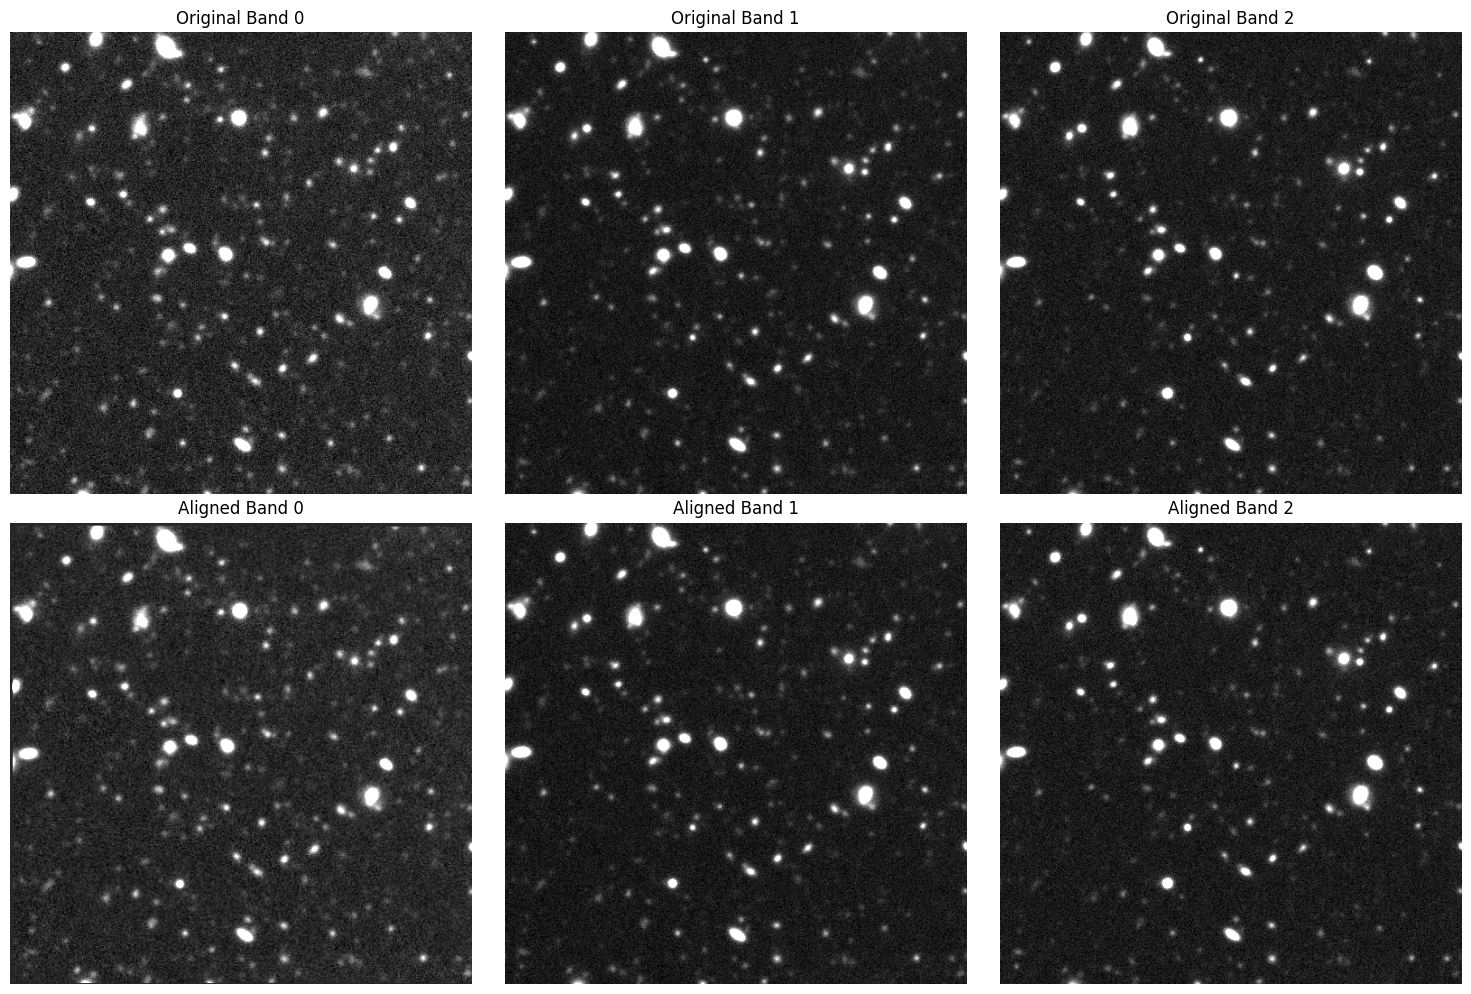

In [66]:
model.load_state_dict(torch.load('superpoint_best.pth'))
model.eval()
ds_eval = RubinTileDataset(TILE_DIR, augment=False)  # No augmentation!
dl_eval = DataLoader(ds_eval, batch_size=2, shuffle=False, num_workers=2)

img, var, msk = next(iter(dl_eval))
print(f"Original: {img.shape}")

# Align bands within each tile
aligned_img = align_tile_bands(img, model, reference_band=1)  # use band 1 (g-band?) as ref
print(f"Aligned: {aligned_img.shape}")

# Visualize before/after for one tile
tile_idx = 0
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for b in range(3):
    # Before
    raw_np = img[tile_idx, b].numpy()
    lo, hi = np.percentile(raw_np, (1, 99))
    axs[0, b].imshow(raw_np, origin='lower', cmap='gray', vmin=lo, vmax=hi)
    axs[0, b].set_title(f'Original Band {b}')
    axs[0, b].axis('off')
    
    # After
    aligned_np = aligned_img[tile_idx, b].numpy()
    axs[1, b].imshow(aligned_np, origin='lower', cmap='gray', vmin=lo, vmax=hi)
    axs[1, b].set_title(f'Aligned Band {b}')
    axs[1, b].axis('off')

plt.tight_layout()
plt.show()

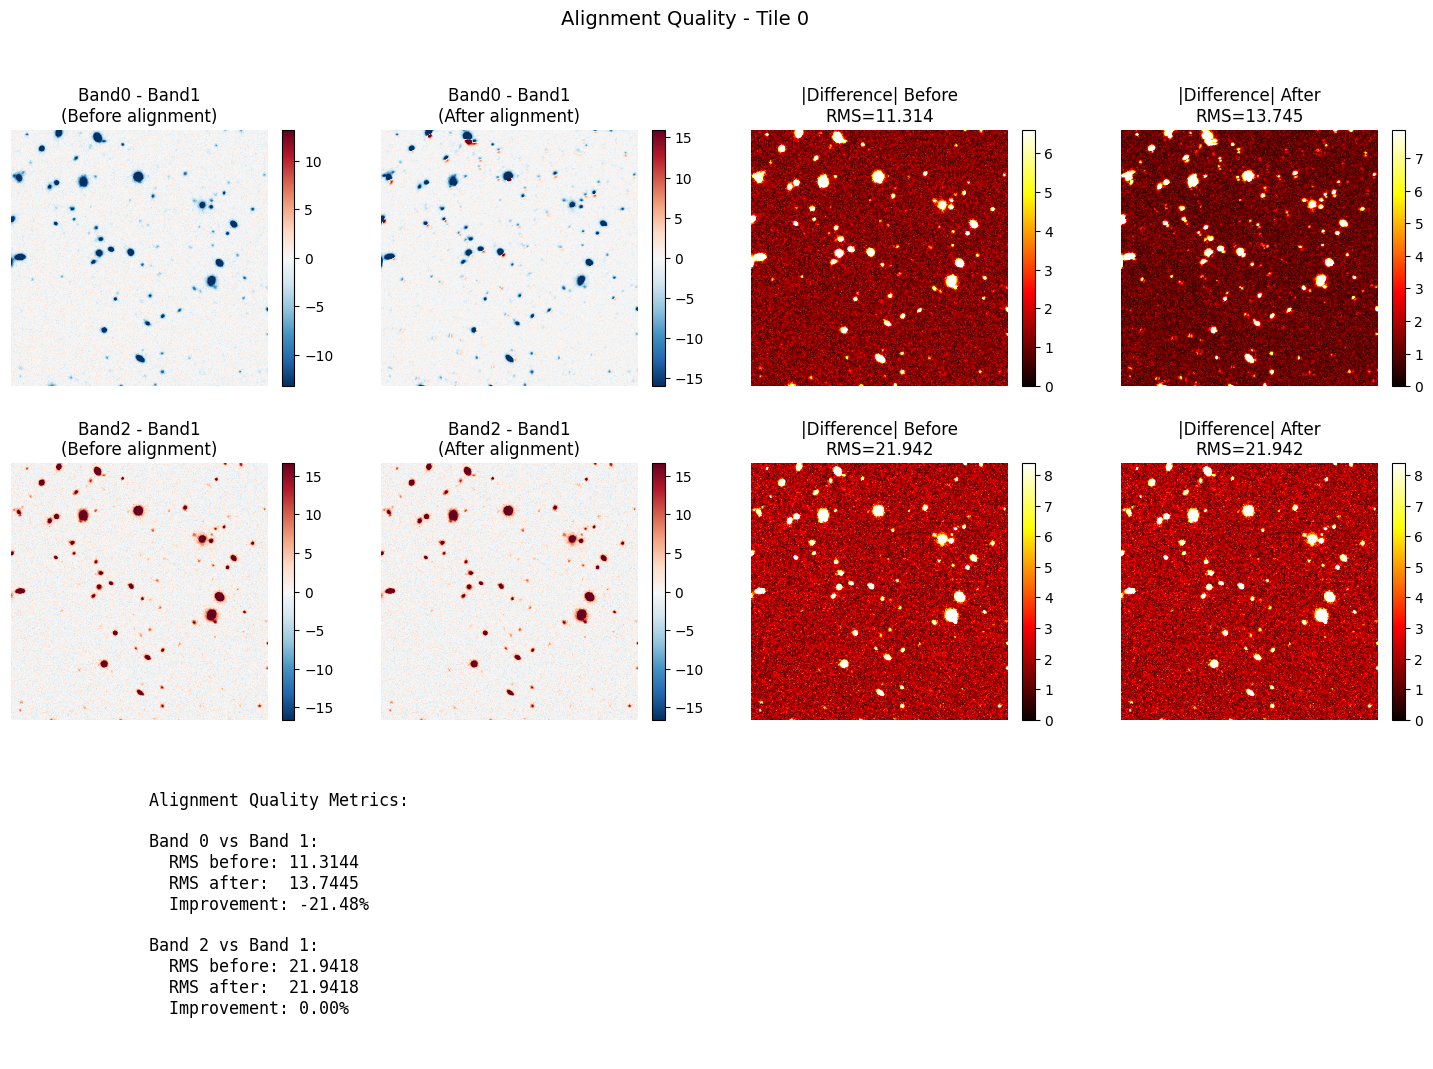

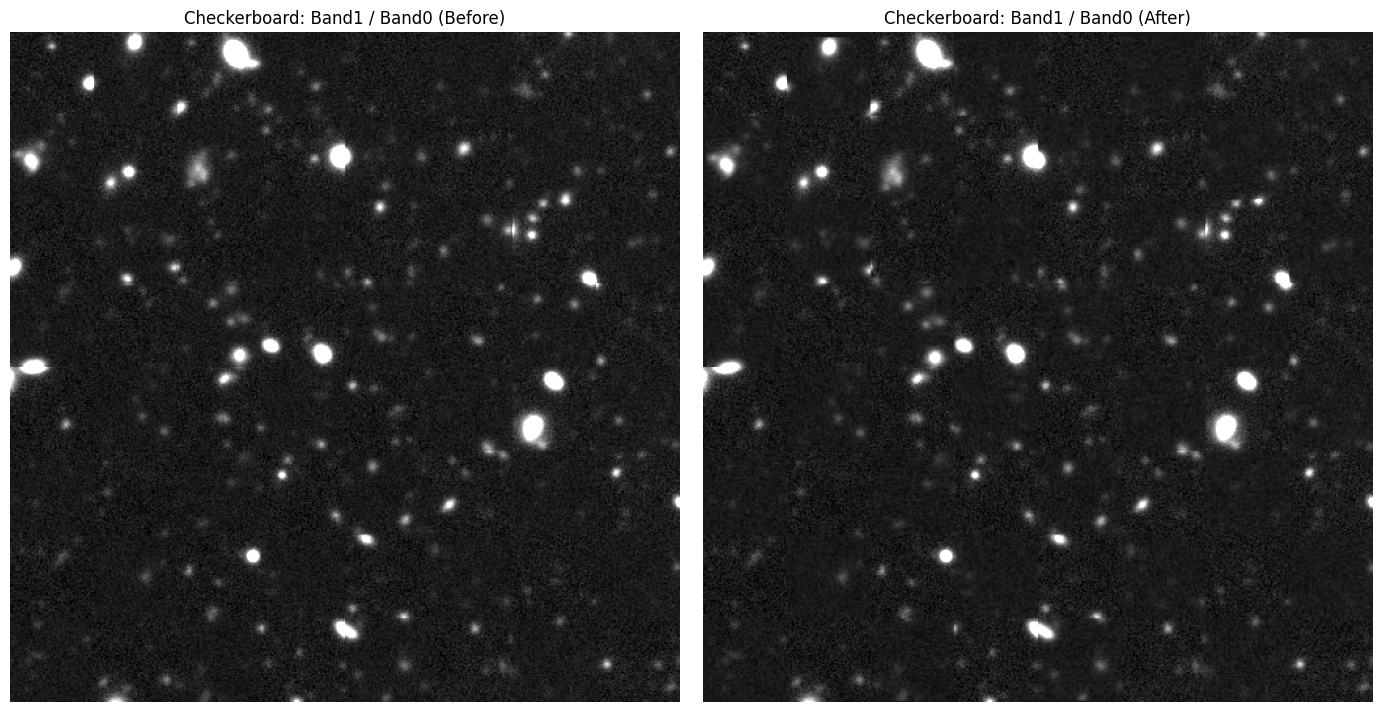

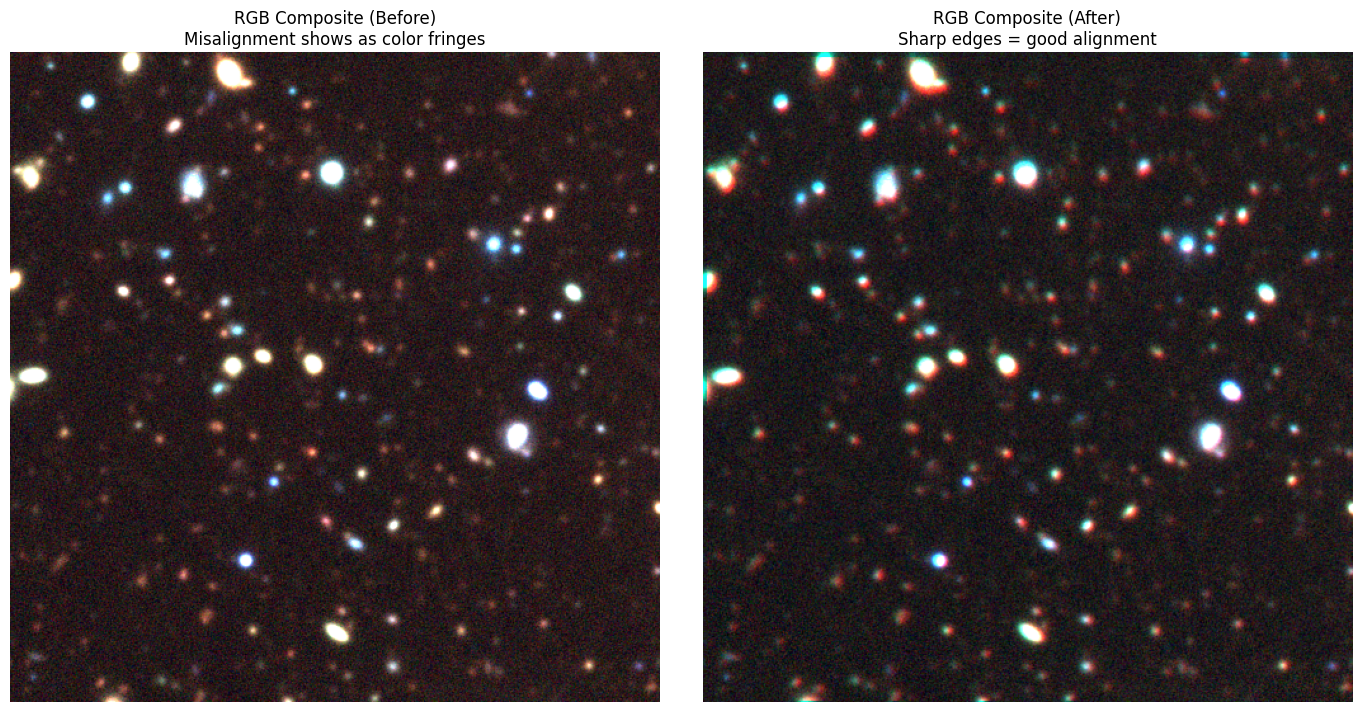

In [67]:
def visualize_alignment_quality(img_before, img_after, tile_idx=0):
    """
    Show subtle alignment differences with multiple diagnostic views.
    """
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
    
    # Use band 1 as reference
    ref_band = 1
    ref_before = img_before[tile_idx, ref_band].numpy()
    ref_after = img_after[tile_idx, ref_band].numpy()
    
    # Normalize for display
    lo, hi = np.percentile(ref_before, (1, 99))
    
    for b in range(3):
        if b == ref_band:
            continue
        
        band_before = img_before[tile_idx, b].numpy()
        band_after = img_after[tile_idx, b].numpy()
        
        row = 0 if b == 0 else 1
        
        # 1. Difference image (before alignment)
        diff_before = band_before - ref_before
        ax1 = fig.add_subplot(gs[row, 0])
        vmax = np.percentile(np.abs(diff_before), 99)
        im1 = ax1.imshow(diff_before, origin='lower', cmap='RdBu_r', 
                        vmin=-vmax, vmax=vmax)
        ax1.set_title(f'Band{b} - Band{ref_band}\n(Before alignment)')
        ax1.axis('off')
        plt.colorbar(im1, ax=ax1, fraction=0.046)
        
        # 2. Difference image (after alignment)
        diff_after = band_after - ref_after
        ax2 = fig.add_subplot(gs[row, 1])
        vmax = np.percentile(np.abs(diff_after), 99)
        im2 = ax2.imshow(diff_after, origin='lower', cmap='RdBu_r',
                        vmin=-vmax, vmax=vmax)
        ax2.set_title(f'Band{b} - Band{ref_band}\n(After alignment)')
        ax2.axis('off')
        plt.colorbar(im2, ax=ax2, fraction=0.046)
        
        # 3. Absolute difference (before)
        ax3 = fig.add_subplot(gs[row, 2])
        abs_diff_before = np.abs(diff_before)
        im3 = ax3.imshow(abs_diff_before, origin='lower', cmap='hot',
                        vmin=0, vmax=np.percentile(abs_diff_before, 98))
        ax3.set_title(f'|Difference| Before\nRMS={np.std(diff_before):.3f}')
        ax3.axis('off')
        plt.colorbar(im3, ax=ax3, fraction=0.046)
        
        # 4. Absolute difference (after)
        ax4 = fig.add_subplot(gs[row, 3])
        abs_diff_after = np.abs(diff_after)
        im4 = ax4.imshow(abs_diff_after, origin='lower', cmap='hot',
                        vmin=0, vmax=np.percentile(abs_diff_after, 98))
        ax4.set_title(f'|Difference| After\nRMS={np.std(diff_after):.3f}')
        ax4.axis('off')
        plt.colorbar(im4, ax=ax4, fraction=0.046)
    
    # Summary statistics in bottom row
    ax_summary = fig.add_subplot(gs[2, :])
    ax_summary.axis('off')
    
    summary_text = "Alignment Quality Metrics:\n\n"
    for b in range(3):
        if b == ref_band:
            continue
        band_before = img_before[tile_idx, b].numpy()
        band_after = img_after[tile_idx, b].numpy()
        
        diff_before = band_before - ref_before
        diff_after = band_after - ref_after
        
        rms_before = np.std(diff_before)
        rms_after = np.std(diff_after)
        improvement = (1 - rms_after/rms_before) * 100
        
        summary_text += f"Band {b} vs Band {ref_band}:\n"
        summary_text += f"  RMS before: {rms_before:.4f}\n"
        summary_text += f"  RMS after:  {rms_after:.4f}\n"
        summary_text += f"  Improvement: {improvement:.2f}%\n\n"
    
    ax_summary.text(0.1, 0.5, summary_text, fontsize=12, family='monospace',
                   verticalalignment='center')
    
    plt.suptitle(f'Alignment Quality - Tile {tile_idx}', fontsize=14, y=0.98)
    plt.show()


def visualize_checkerboard(img_before, img_after, tile_idx=0, ref_band=1, target_band=0, block_size=64):
    """
    Checkerboard visualization to see alignment at different spatial locations.
    """
    ref = img_after[tile_idx, ref_band].numpy()
    target_before = img_before[tile_idx, target_band].numpy()
    target_after = img_after[tile_idx, target_band].numpy()
    
    # Normalize
    lo, hi = np.percentile(ref, (1, 99))
    
    # Create checkerboard masks
    H, W = ref.shape
    checker_before = np.copy(ref)
    checker_after = np.copy(ref)
    
    for i in range(0, H, block_size):
        for j in range(0, W, block_size):
            if ((i // block_size) + (j // block_size)) % 2 == 0:
                checker_before[i:i+block_size, j:j+block_size] = target_before[i:i+block_size, j:j+block_size]
                checker_after[i:i+block_size, j:j+block_size] = target_after[i:i+block_size, j:j+block_size]
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    
    axs[0].imshow(checker_before, origin='lower', cmap='gray', vmin=lo, vmax=hi)
    axs[0].set_title(f'Checkerboard: Band{ref_band} / Band{target_band} (Before)')
    axs[0].axis('off')
    
    axs[1].imshow(checker_after, origin='lower', cmap='gray', vmin=lo, vmax=hi)
    axs[1].set_title(f'Checkerboard: Band{ref_band} / Band{target_band} (After)')
    axs[1].axis('off')
    
    plt.tight_layout()
    plt.show()


def visualize_rgb_overlay(img_before, img_after, tile_idx=0):
    """
    RGB false-color overlay to see chromatic misalignment.
    Red=Band0, Green=Band1, Blue=Band2
    """
    def make_rgb(img_data, tile_idx):
        rgb = np.zeros((512, 512, 3))
        for i in range(3):
            band = img_data[tile_idx, i].numpy()
            lo, hi = np.percentile(band, (1, 99))
            rgb[:, :, i] = np.clip((band - lo) / (hi - lo), 0, 1)
        return rgb
    
    rgb_before = make_rgb(img_before, tile_idx)
    rgb_after = make_rgb(img_after, tile_idx)
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    
    axs[0].imshow(rgb_before, origin='lower')
    axs[0].set_title('RGB Composite (Before)\nMisalignment shows as color fringes')
    axs[0].axis('off')
    
    axs[1].imshow(rgb_after, origin='lower')
    axs[1].set_title('RGB Composite (After)\nSharp edges = good alignment')
    axs[1].axis('off')
    
    plt.tight_layout()
    plt.show()


# ===== USE ALL VISUALIZATIONS =====
visualize_alignment_quality(img, aligned_img, tile_idx=0)
visualize_checkerboard(img, aligned_img, tile_idx=0, ref_band=1, target_band=0, block_size=64)
visualize_rgb_overlay(img, aligned_img, tile_idx=0)

In [64]:
# 1. Make sure you're using NON-augmented data for evaluation
ds_eval = RubinTileDataset(TILE_DIR, augment=False)  # No augmentation!
dl_eval = DataLoader(ds_eval, batch_size=2, shuffle=False, num_workers=2)

# 2. Load the trained model
model.load_state_dict(torch.load('superpoint_best.pth'))
model.eval()

# 3. Get fresh test data
img, var, msk = next(iter(dl_eval))

# 4. Deep diagnostic
print("="*60)
print("DESCRIPTOR QUALITY CHECK")
print("="*60)

ref_img = img[0, 1]  # First tile, band 1
tgt_img = img[0, 0]  # First tile, band 0

xs_ref, ys_ref, desc_ref, _ = detect_keypoints_multiband(
    ref_img, model, nms_ks=11, thr_rel=0.3, max_peaks=200
)
xs_tgt, ys_tgt, desc_tgt, _ = detect_keypoints_multiband(
    tgt_img, model, nms_ks=11, thr_rel=0.3, max_peaks=200
)

print(f"\nKeypoints detected:")
print(f"  Band 1: {len(xs_ref)}")
print(f"  Band 0: {len(xs_tgt)}")

# Check descriptor statistics
desc_ref_np = desc_ref.numpy()
desc_tgt_np = desc_tgt.numpy()

print(f"\nDescriptor statistics (Band 1):")
print(f"  Mean: {desc_ref_np.mean():.6f}")
print(f"  Std: {desc_ref_np.std():.6f}")
print(f"  Min: {desc_ref_np.min():.6f}")
print(f"  Max: {desc_ref_np.max():.6f}")

print(f"\nDescriptor statistics (Band 0):")
print(f"  Mean: {desc_tgt_np.mean():.6f}")
print(f"  Std: {desc_tgt_np.std():.6f}")
print(f"  Min: {desc_tgt_np.min():.6f}")
print(f"  Max: {desc_tgt_np.max():.6f}")

# Pairwise distances
from scipy.spatial.distance import cdist
dists = cdist(desc_ref_np, desc_tgt_np, metric='euclidean')

print(f"\nPairwise descriptor distances:")
print(f"  Min: {dists.min():.6f}")
print(f"  Mean: {dists.mean():.6f}")
print(f"  Max: {dists.max():.6f}")
print(f"  Std: {dists.std():.6f}")

# Check if descriptors collapsed (all same)
desc_self_dist = cdist(desc_ref_np, desc_ref_np, metric='euclidean')
np.fill_diagonal(desc_self_dist, np.inf)  # Ignore self-distances
print(f"\nWithin-band descriptor diversity (Band 1):")
print(f"  Min distance between different keypoints: {desc_self_dist.min():.6f}")
print(f"  Mean: {desc_self_dist.mean():.6f}")

# Ratio test analysis
matches_at_different_thresholds = {}
for thresh in [0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
    matches = match_keypoints(desc_ref, desc_tgt, ratio_thresh=thresh)
    matches_at_different_thresholds[thresh] = len(matches)
    print(f"  Ratio threshold {thresh:.2f}: {len(matches)} matches")

print(f"\nSpatial check:")
coords_ref = np.column_stack([xs_ref.numpy(), ys_ref.numpy()])
coords_tgt = np.column_stack([xs_tgt.numpy(), ys_tgt.numpy()])
spatial_dists = cdist(coords_ref, coords_tgt, metric='euclidean')
close_spatial = (spatial_dists < 5).any(axis=1).sum()
print(f"  Keypoints with spatial match within 5px: {close_spatial}/{len(xs_ref)}")

DESCRIPTOR QUALITY CHECK

Keypoints detected:
  Band 1: 200
  Band 0: 200

Descriptor statistics (Band 1):
  Mean: 0.003763
  Std: 0.124943
  Min: -0.201028
  Max: 0.203831

Descriptor statistics (Band 0):
  Mean: 0.003761
  Std: 0.124943
  Min: -0.201092
  Max: 0.203479

Pairwise descriptor distances:
  Min: 0.001372
  Mean: 0.004045
  Max: 0.012701
  Std: 0.001139

Within-band descriptor diversity (Band 1):
  Min distance between different keypoints: 0.001504
  Mean: inf
  Ratio threshold 0.60: 2 matches
  Ratio threshold 0.70: 4 matches
  Ratio threshold 0.75: 4 matches
  Ratio threshold 0.80: 11 matches
  Ratio threshold 0.85: 24 matches
  Ratio threshold 0.90: 49 matches
  Ratio threshold 0.95: 97 matches

Spatial check:
  Keypoints with spatial match within 5px: 35/200
